# Übung: GIS in Python

Bis jetzt haben wir noch nicht mit eigentlich Geodaten gearbeitet. Die x / y Werte der Zeckenstiche repräsentatieren zwar Zeckenstiche in der Schweiz (sie sind also im Schweizer Koordinatensystem), dies ist aber nur uns bewusst (Python weiss davon nichts). Der Raumbezug fehlt noch, und den stellen wir an dieser Stelle her. Warum? Weil wir im nächsten Schritt unserer Todo Liste (s.u.) berechnen müssen, wie viele Zeckenstiche sich im Wald befinden. Das ist eine räumliche Abfrage, die sich ohne räumliche Objekte nicht bewerkstelligen lässt.


- Schritt 1: Einen Einzelpunkt zufällig verschieben ✓
- Schritt 2: Alle Punkte einer DataFrame zufällig verschieben (1 "Run") ✓
- Schritt 3: Alle Punkte einer DataFrame mehrfach zufällig verschieben (z.B. 50 "Runs") ✓
- **Schritt 4: Anteil der Punkte im Wald pro "Run" ermitteln**

Um mit Geodaten in Python arbeiten zu können, müssen wir ein neues Modul importieren. Im Grunde genommen sind Vektordaten nicht mehr als Tabellen mit einer zusätzlichen "Geometrie"-Spalte. Dementsprechend müssen wir `pandas` nur ein bisschen erweitern um mit Vektordaten arbeiten zu können, und diese "Geo"-Erweiterung lautet: `geopandas`. 

[//]: # (How do we handle people working on the server vs. people working locally?)

In [ ]:
%matplotlib inline 

In [52]:
# Vorbereitung der Arbeitsumgebung 
# (nur wenn ihr in einer neuen Session startet)

import pandas as pd
import random
zeckenstiche = pd.read_csv("zeckenstiche.csv")

def offset_coordinate(old, distance = 1000):
    new = old + random.normalvariate(0,distance)
    return(new)

monte_carlo = []
for i in range(5):
    zeckenstiche_sim = pd.DataFrame()

    zeckenstiche_sim["ID"] = zeckenstiche["ID"]

    zeckenstiche_sim["x"] = zeckenstiche["x"].apply(offset_coordinate)
    zeckenstiche_sim["y"] = zeckenstiche["y"].apply(offset_coordinate)
    zeckenstiche_sim["Run_Nr"] = i
    monte_carlo.append(zeckenstiche_sim)
    
monte_carlo_df = pd.concat(monte_carlo)

## Übung 1: *DataFrame* zu *GeoDataFrame*

Wie erwähnt sind die Zeckenstichdaten bisher lediglich als tabellarische Daten vorhanden. In ArcGIS Terminologie müssen wir die Operation "[XY Table to Point](https://pro.arcgis.com/de/pro-app/tool-reference/data-management/xy-table-to-point.htm)" durchführen. In Python heisst das: Wir wandeln eine *DataFrame* in eine *GeoDataFrame* um. Zuerst erstellen wir eine Geometrie-Spalte aus den xy-Koordinaten mit der Funktion `points_from_xy` aus dem Modul `geopandas`.

In [54]:
import geopandas as gpd


monte_carlo_df["geometry"] = gpd.points_from_xy(monte_carlo_df.x, monte_carlo_df.y)



In [55]:
type(monte_carlo_df)

pandas.core.frame.DataFrame

Der Datensatz `monte_carlo_df` hat jetzt aber noch nicht begriffen, dass es jetzt eine *GeoDataFrame* ist. Dies müssen wir dem Objekt erst noch mitteilen:

In [56]:
monte_carlo_df = gpd.GeoDataFrame(monte_carlo_df)

type(monte_carlo_df)

geopandas.geodataframe.GeoDataFrame

Jetzt, wo zeckenstiche eine GeoDataFrame ist, gibt es einen einfachen weg die Punkte räumlich zu visualisieren:

<AxesSubplot:>

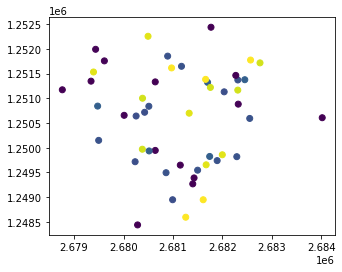

In [60]:
monte_carlo_df.plot(column = "ID")

## Übung 2: Koordinatensystem festlegen

Wir wissen zwar, das unsere *GeoDataFrame* in Schweizer Landeskoordinaten (CH1903 LV95) zu verstehen ist, aber dies haben wir noch nirgends festgehalten. Das Koordinatensystem (Coordinate Reference System, CRS) können wir über das Attribut `crs` der *GeoDataFrame* festhalten. Das Koordinatensystem CH1903 LV95 hat den EPSG Code 2056, demnach muss das CRS folgendermassen festgelegt werden:


In [61]:
monte_carlo_df = monte_carlo_df.set_crs(epsg = 2056)

Nun ist das Koordinatensystem (*CRS*) als Attribut der *GeoDataFrame* gespeichert:

In [62]:
monte_carlo_df.crs

<Projected CRS: EPSG:2056>
Name: CH1903+ / LV95
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Europe - Liechtenstein and Switzerland
- bounds: (5.96, 45.82, 10.49, 47.81)
Coordinate Operation:
- name: Swiss Oblique Mercator 1995
- method: Hotine Oblique Mercator (variant B)
Datum: CH1903+
- Ellipsoid: Bessel 1841
- Prime Meridian: Greenwich

## Übung 3: Zeckenstiche als Shapefile exportieren

Zum Schluss exportieren wir unser Datensatz in ein Shapefile, damit wir das nächste Mal direkt mit einer *GeoDataFrame* arbeiten können. Genau wie wir in einer vorherigen Übung eine pandas DataFrame mit `.to_csv` in eine csv exportiert haben, gibt es für GeoDataFrames die Methode `.to_file`. Exportiere zeckenstiche mit dieser Methode in eine Shapefile.

In [63]:
# Musterlösung

monte_carlo_df.to_file("monte_carlo_df.shp")

## Übung 4 (Optional): Export als Geopackage

Shapefiles sind ein ganz schreckliches Format (siehe [switchfromshapefile.org](http://switchfromshapefile.org/)). Viel praktischer sind an dieser Stelel zum Beispiel *Geopackages*. Ihr könnt `monte_carlo_df` auch mit folgender Codezeile als *Geopackage* exportieren.

In [64]:
monte_carlo_df.to_file("monte_carlo_df.gpkg", layer = "monte_carlo_simulation",driver = "GPKG")